In [3]:
import warnings
warnings.simplefilter('ignore', (FutureWarning, DeprecationWarning))

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.bbox"] = 'tight'
np.set_printoptions(precision=3, suppress=True)
import pandas as pd
pd.set_option('precision', 3)
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale, StandardScaler

In [4]:
rng = np.random.RandomState(0)
n_samples_1 = 1000
n_samples_2 = 100
X_syn = np.r_[1.5 * rng.randn(n_samples_1, 2),
        0.5 * rng.randn(n_samples_2, 2) + [2, 2]]
y_syn = np.array([0] * (n_samples_1) + [1] * (n_samples_2))
X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn)

In [5]:
from sklearn.datasets import fetch_openml
# mammography dataset https://www.openml.org/d/310
data = fetch_openml('mammography')
X, y = data.data, data.target
y = (y.astype(np.int) + 1) // 2

In [6]:
X.shape

(11183, 6)

In [7]:
np.bincount(y)

array([10923,   260])

In [8]:
df = pd.DataFrame(X)

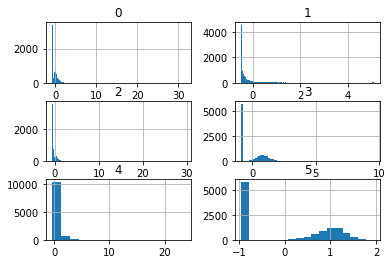

In [9]:
df.hist(bins='auto');

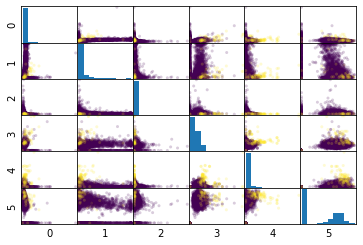

In [10]:
axes = pd.plotting.scatter_matrix(df, c=y, alpha=.2);
for ax in axes.ravel():
    ax.set_xticks(())
    ax.set_yticks(())
plt.savefig('images/mammography_data.png')

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

# Plotting caveat

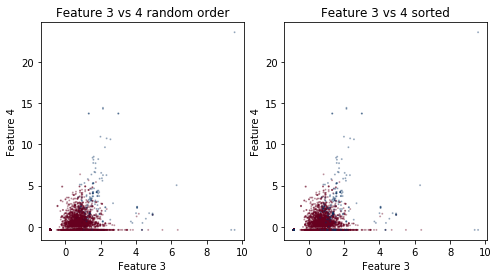

In [19]:
sorting = np.argsort(y_train)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].scatter(X_train[:, 3], X_train[:, 4], c=y_train[:], alpha=.3, s=1, cmap='RdBu')
axes[1].scatter(X_train[sorting, 3], X_train[sorting, 4], c=y_train[sorting], alpha=.3, s=1, cmap='RdBu')
axes[0].set_title("Feature 3 vs 4 random order")
axes[1].set_title("Feature 3 vs 4 sorted")
for ax in axes:
    ax.set_xlabel("Feature 3")
    ax.set_ylabel("Feature 4")
plt.savefig("images/mammography_features23.png")

In [20]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

scores = cross_validate(LogisticRegression(),
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9202523350276881, 0.6335760292641773)

In [21]:
from sklearn.ensemble import RandomForestClassifier
scores = cross_validate(RandomForestClassifier(),
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9386477254737844, 0.7390135686211157)

# Imbalanced-Learn

In [24]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(replacement=False)
X_train_subsample, y_train_subsample = rus.fit_sample(X_train, y_train)
print(X_train.shape)
print(X_train_subsample.shape)
print(np.bincount(y_train_subsample))

(8387, 6)
(390, 6)
[195 195]


In [25]:
from imblearn.pipeline import make_pipeline as make_imb_pipeline

undersample_pipe = make_imb_pipeline(RandomUnderSampler(), LogisticRegression())
scores = cross_validate(undersample_pipe,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9153663317142137, 0.5424687323147982)

In [26]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_train_oversample, y_train_oversample = ros.fit_sample(X_train, y_train)
print(X_train.shape)
print(X_train_oversample.shape)
print(np.bincount(y_train_oversample))

(8387, 6)
(16384, 6)
[8192 8192]


In [27]:
oversample_pipe = make_imb_pipeline(RandomOverSampler(), LogisticRegression())
scores = cross_validate(oversample_pipe,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9181187255192389, 0.5835049778758015)

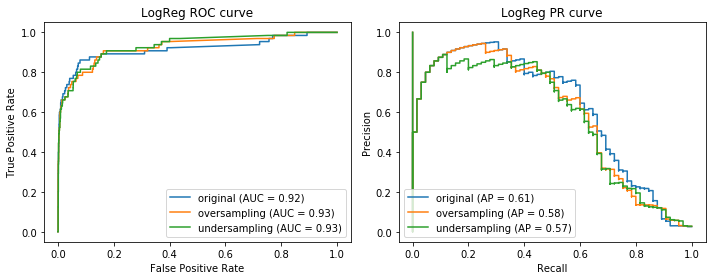

In [72]:
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
oversample_pipe.fit(X_train, y_train)
undersample_pipe.fit(X_train, y_train)
lr = LogisticRegression().fit(X_train, y_train)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_roc_curve(lr, X_test, y_test, name="original", ax=axes[0])
plot_roc_curve(oversample_pipe, X_test, y_test, name="oversampling", ax=axes[0])
plot_roc_curve(undersample_pipe, X_test, y_test, name="undersampling", ax=axes[0])
axes[0].set_title("LogReg ROC curve")

plot_precision_recall_curve(lr, X_test, y_test, name="original", ax=axes[1])
plot_precision_recall_curve(oversample_pipe, X_test, y_test, name="oversampling", ax=axes[1])
plot_precision_recall_curve(undersample_pipe, X_test, y_test, name="undersampling", ax=axes[1])
axes[1].set_title("LogReg PR curve")
plt.tight_layout()
plt.savefig("images/curves_logreg.png")

In [29]:
undersample_pipe_rf = make_imb_pipeline(RandomUnderSampler(), RandomForestClassifier())
scores = cross_validate(undersample_pipe_rf,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9476573038286773, 0.5809993110917689)

In [30]:
oversample_pipe_rf = make_imb_pipeline(RandomOverSampler(), RandomForestClassifier())
scores = cross_validate(oversample_pipe_rf,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9261659973887187, 0.7139288822315434)

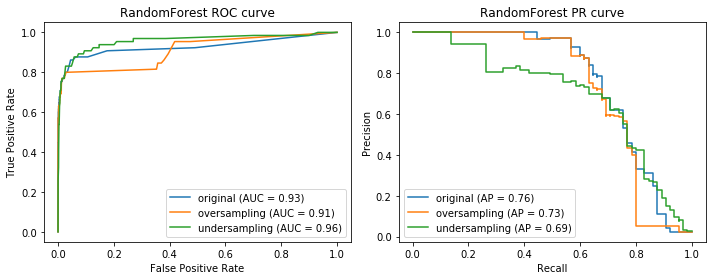

In [76]:
oversample_pipe_rf.fit(X_train, y_train)
undersample_pipe_rf.fit(X_train, y_train)

rf = RandomForestClassifier(random_state=1).fit(X_train, y_train)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_roc_curve(rf, X_test, y_test, name="original", ax=axes[0])
plot_roc_curve(oversample_pipe_rf, X_test, y_test, name="oversampling", ax=axes[0])
plot_roc_curve(undersample_pipe_rf, X_test, y_test, name="undersampling", ax=axes[0])
axes[0].set_title("RandomForest ROC curve")

plot_precision_recall_curve(rf, X_test, y_test, name="original", ax=axes[1])
plot_precision_recall_curve(oversample_pipe_rf, X_test, y_test, name="oversampling", ax=axes[1])
plot_precision_recall_curve(undersample_pipe_rf, X_test, y_test, name="undersampling", ax=axes[1])
axes[1].set_title("RandomForest PR curve")
plt.tight_layout()
plt.savefig("images/curves_rf.png")

# Class Weights

In [32]:
scores = cross_validate(LogisticRegression(class_weight='balanced'),
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9190730343682848, 0.5815811057723485)

In [33]:
scores = cross_validate(RandomForestClassifier(class_weight='balanced'),
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9190434184272439, 0.7105773410221594)

# Resampled Ensembles

In [79]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier
resampled_rf = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_features='auto'),
                                         random_state=0)

In [35]:
scores = cross_validate(resampled_rf,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9487440967960865, 0.5449746697187694)

In [36]:
from imblearn.ensemble import BalancedRandomForestClassifier
resampled_rf2 = BalancedRandomForestClassifier(random_state=0)
scores = cross_validate(resampled_rf2,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9495292013648882, 0.6490784973162692)

In [37]:
resampled_lr = BalancedBaggingClassifier(LogisticRegression(),
                                         random_state=0)

scores = cross_validate(resampled_lr,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9187876821509684, 0.5525785992670369)

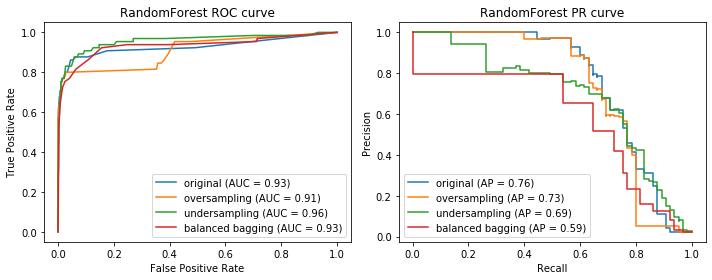

In [80]:
resampled_rf.fit(X_train, y_train)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_roc_curve(rf, X_test, y_test, name="original", ax=axes[0])
plot_roc_curve(oversample_pipe_rf, X_test, y_test, name="oversampling", ax=axes[0])
plot_roc_curve(undersample_pipe_rf, X_test, y_test, name="undersampling", ax=axes[0])
plot_roc_curve(resampled_rf, X_test, y_test, name="balanced bagging", ax=axes[0])
axes[0].set_title("RandomForest ROC curve")

plot_precision_recall_curve(rf, X_test, y_test, name="original", ax=axes[1])
plot_precision_recall_curve(oversample_pipe_rf, X_test, y_test, name="oversampling", ax=axes[1])
plot_precision_recall_curve(undersample_pipe_rf, X_test, y_test, name="undersampling", ax=axes[1])
plot_precision_recall_curve(resampled_rf, X_test, y_test, name="balanced bagging", ax=axes[1])

axes[1].set_title("RandomForest PR curve")

plt.tight_layout()
plt.savefig("images/roc_vs_pr.png", dpi=500)

In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_test, undersample_pipe_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96      2731
           1       0.23      0.88      0.36        65

    accuracy                           0.93      2796
   macro avg       0.61      0.90      0.66      2796
weighted avg       0.98      0.93      0.95      2796



In [41]:
print(classification_report(y_test, oversample_pipe_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2731
           1       0.82      0.63      0.71        65

    accuracy                           0.99      2796
   macro avg       0.91      0.81      0.85      2796
weighted avg       0.99      0.99      0.99      2796



In [42]:
print(classification_report(y_test, resampled_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98      2731
           1       0.31      0.77      0.44        65

    accuracy                           0.95      2796
   macro avg       0.65      0.86      0.71      2796
weighted avg       0.98      0.95      0.96      2796



# SMOTE

In [47]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)
print(X_train_smote.shape)
print(np.bincount(y_train_smote))

(16384, 6)
[8192 8192]


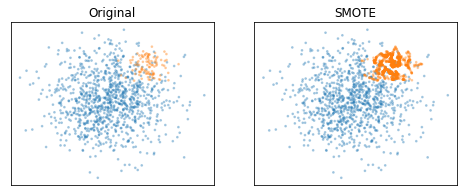

In [54]:
X_resampled, y_resampled = SMOTE().fit_sample(X_syn, y_syn)
fig, axes = plt.subplots(1, 2, figsize=(8, 3), subplot_kw={'xticks':(), 'yticks':()})
axes[0].scatter(X_syn[:, 0], X_syn[:, 1], c=plt.cm.tab10(y_syn), alpha=.3, s=3)
axes[1].scatter(X_resampled[:, 0], X_resampled[:, 1], c=plt.cm.tab10(y_resampled), alpha=.3, s=3)
axes[0].set_title("Original")
axes[1].set_title("SMOTE")
plt.savefig("images/smote.png")

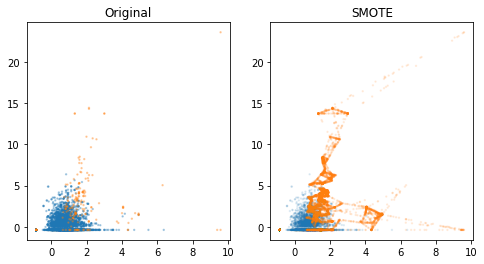

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
sorting = np.argsort(y_train)
axes[0].scatter(X_train[sorting, 3], X_train[sorting, 4], c=plt.cm.tab10(y_train[sorting]), alpha=.3, s=2)
axes[1].scatter(X_train_smote[:, 3], X_train_smote[:, 4], c=plt.cm.tab10(y_train_smote), alpha=.1, s=2)
axes[0].set_title("Original")
axes[1].set_title("SMOTE")
plt.savefig("images/smote_mammography.png")

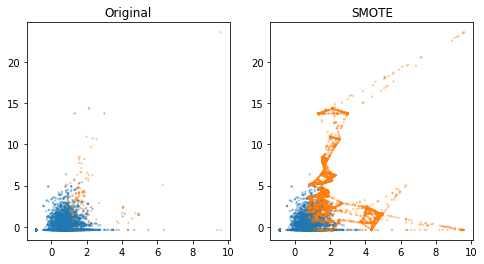

In [58]:
from sklearn.utils import shuffle
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
X_smote_sh, y_smote_sh = shuffle(X_train_smote, y_train_smote)
axes[0].scatter(X_train[:, 3], X_train[:, 4], c=plt.cm.tab10(y_train), alpha=.3, s=2)
axes[1].scatter(X_smote_sh[:, 3], X_smote_sh[:, 4], c=plt.cm.tab10(y_smote_sh), alpha=.3, s=2)
axes[0].set_title("Original")
axes[1].set_title("SMOTE")
#plt.savefig("images/smote_mammography_shuffled.png")

In [59]:
smote_pipe = make_imb_pipeline(SMOTE(), LogisticRegression())
scores = cross_validate(smote_pipe, X_train, y_train, cv=10,
                        scoring=('roc_auc', 'average_precision'))
pd.DataFrame(scores)[['test_roc_auc', 'test_average_precision']].mean()

test_roc_auc              0.919
test_average_precision    0.585
dtype: float64

In [60]:
smote_pipe_rf = make_imb_pipeline(SMOTE(), RandomForestClassifier())
scores = cross_validate(smote_pipe_rf, X_train, y_train, cv=10,
                        scoring=('roc_auc', 'average_precision'))
pd.DataFrame(scores)[['test_roc_auc', 'test_average_precision']].mean()

test_roc_auc              0.945
test_average_precision    0.695
dtype: float64

In [61]:
from sklearn.model_selection import GridSearchCV
param_grid = {'smote__k_neighbors': [3, 5, 7, 9, 11, 15, 31]}
search = GridSearchCV(smote_pipe_rf, param_grid, cv=10, return_train_score=True, scoring="average_precision")
search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('smote',
                                        SMOTE(k_neighbors=5, n_jobs=None,
                                              random_state=None,
                                              sampling_strategy='auto')),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                       

In [62]:
search.best_score_

0.7014540144406991

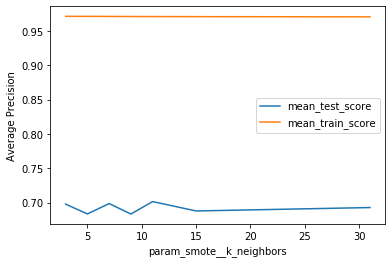

In [63]:
results = pd.DataFrame(search.cv_results_)
results.plot("param_smote__k_neighbors", ["mean_test_score", "mean_train_score"])
plt.ylabel("Average Precision")
plt.savefig("images/param_smote_k_neighbors.png")

In [64]:
smote_pipe_rf = make_imb_pipeline(SMOTE(k_neighbors=11), RandomForestClassifier())
scores = cross_validate(smote_pipe_rf, X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9498361327019864, 0.6977157349203014)

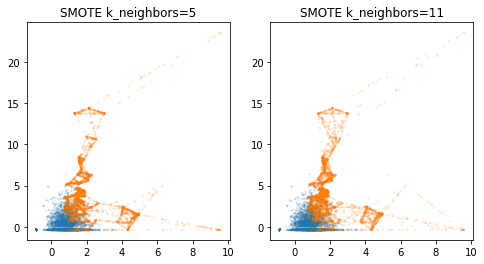

In [67]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(k_neighbors=11)
X_train_smote11, y_train_smote11 = smote.fit_sample(X_train, y_train)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
X_smote_sh11, y_smote_sh11 = shuffle(X_train_smote11, y_train_smote11)
axes[0].scatter(X_smote_sh[:, 3], X_smote_sh[:, 4], c=plt.cm.tab10(y_smote_sh), alpha=.1, s=2)
axes[1].scatter(X_smote_sh11[:, 3], X_smote_sh11[:, 4], c=plt.cm.tab10(y_smote_sh11), alpha=.1, s=2)
axes[0].set_title("SMOTE k_neighbors=5")
axes[1].set_title("SMOTE k_neighbors=11")
plt.savefig("images/smote_k_neighbors.png")

In [68]:
smote_pipe_rf.fit(X_train, y_train)
probs_smote_pipe_rf = smote_pipe_rf.predict_proba(X_test)[:, 1]
fpr_smote_pipe_rf, tpr_smote_pipe_rf, _ = roc_curve(y_test, probs_smote_pipe_rf)
precision_smote_pipe_rf, recall_smote_pipe_rf, _ = precision_recall_curve(y_test, probs_smote_pipe_rf)

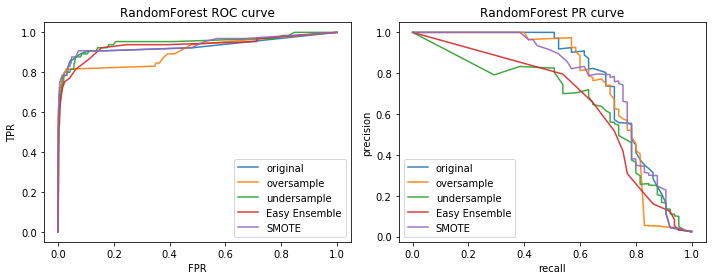

In [69]:

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(fpr_org, tpr_org, label="original", alpha=.9)
axes[0].plot(fpr_over, tpr_over, label="oversample", alpha=.9)
axes[0].plot(fpr_under, tpr_under, label="undersample", alpha=.9)
axes[0].plot(fpr_ee, tpr_ee, label="Easy Ensemble", alpha=.9)
axes[0].plot(fpr_smote_pipe_rf, tpr_smote_pipe_rf, label="SMOTE", alpha=.9)

axes[0].legend()
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].set_title("RandomForest ROC curve")

axes[1].plot(recall_org, precision_org, label="original", alpha=.9)
axes[1].plot(recall_over, precision_over, label="oversample", alpha=.9)
axes[1].plot(recall_under, precision_under, label="undersample", alpha=.9)
axes[1].plot(recall_ee, precision_ee, label="Easy Ensemble", alpha=.9)
axes[1].plot(recall_smote_pipe_rf, precision_smote_pipe_rf, label="SMOTE", alpha=.9)

axes[1].legend()
axes[1].set_xlabel("recall")
axes[1].set_ylabel("precision")
axes[1].set_title("RandomForest PR curve")
plt.tight_layout()
plt.savefig("images/roc_vs_pr_smote.png", dpi=500)